<td>
   <a target="_blank" href="https://labelbox.com" ><img src="https://labelbox.com/blog/content/images/2021/02/logo-v4.svg" width=256/></a>
</td>

<td>
<a href="https://colab.research.google.com/github/Labelbox/labelbox-python/blob/develop/examples/model_assisted_labeling/tiled_imagery_mal.ipynb" target="_blank"><img
src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
</td>

<td>
<a href="https://github.com/Labelbox/labelbox-python/tree/develop/examples/model_assisted_labeling/tiled_imagery_mal.ipynb" target="_blank"><img
src="https://img.shields.io/badge/GitHub-100000?logo=github&logoColor=white" alt="GitHub"></a>
</td>

# Tiled Imagery Annotation Import
* This notebook will provide examples of each supported annotation type for tiled imagery assets. It will cover the following:
    * Model-assisted labeling - used to provide pre-annotated data for your labelers. This will enable a reduction in the total amount of time to properly label your assets. Model-assisted labeling does not submit the labels automatically, and will need to be reviewed by a labeler for submission.
    * Label Import - used to provide ground truth labels. These can in turn be used and compared against prediction labels, or used as benchmarks to see how your labelers are doing.

* For information on what types of annotations are supported per data type, refer to this documentation:
    * https://docs.labelbox.com/docs/model-assisted-labeling#option-1-import-via-python-annotation-types-recommended

* Notes:
 * This notebook uses the Slippy Maps format
 * If you are importing more than 1,000 mask annotations at a time, consider submitting separate jobs, as they can take longer than other annotation types to import.
 * Wait until the import job is complete before opening the Editor to make sure all annotations are imported properly.

In [ ]:
!pip install -q 'labelbox[data]'

In [2]:
import os

import uuid
import numpy as np
from PIL import Image
import cv2
import ndjson

from labelbox.data.annotation_types.data.tiled_image import TiledBounds, TiledImageData, TileLayer, EPSG, EPSGTransformer
from labelbox.data.serialization.ndjson.converter import NDJsonConverter
from labelbox.schema.media_type import MediaType
from labelbox.data.annotation_types import (
    Label, ImageData, ObjectAnnotation, MaskData,
    Rectangle, Point, Line, Mask, Polygon,
    Radio, Checklist, Text,
    ClassificationAnnotation, ClassificationAnswer
)
from labelbox.schema.ontology import OntologyBuilder, Tool, Classification, Option
from labelbox import Client, LabelingFrontend, LabelImport, MALPredictionImport

# API Key and Client
Provide a valid api key below in order to properly connect to the Labelbox Client.

In [3]:
API_KEY = None
client = Client(api_key=API_KEY)

INFO:labelbox.client:Initializing Labelbox client at 'https://api.labelbox.com/graphql'


---- 
### Steps
1. Make sure project is setup
2. Collect annotations
3. Upload

### Project setup

We will be creating two projects, one for model-assisted labeling, and one for label imports

In [4]:
ontology_builder = OntologyBuilder(
    tools=[
        Tool(tool=Tool.Type.BBOX, name="box"),
        Tool(tool=Tool.Type.LINE, name="line"),
        Tool(tool=Tool.Type.POINT, name="point"),
        Tool(tool=Tool.Type.POLYGON, name="polygon"),    
        Tool(tool=Tool.Type.SEGMENTATION, name="mask")],
    classifications=[
        Classification(class_type=Classification.Type.TEXT, name="text"),
        Classification(class_type=Classification.Type.CHECKLIST, name="checklist", options=[
            Option(value="first_checklist_answer"),
            Option(value="second_checklist_answer")            
        ]),
        Classification(class_type=Classification.Type.RADIO, name="radio", options=[
            Option(value="first_radio_answer"),
            Option(value="second_radio_answer")
        ]),                                      
])

In [5]:
mal_project = client.create_project(name="tiled_imagery_mal_project", media_type=MediaType.Simple_Tile)
li_project = client.create_project(name="tiled_imagery_import_project", media_type=MediaType.Simple_Tile)


dataset = client.create_dataset(name="tiled_imagery_annotation_import_demo_dataset")
editor = next(client.get_labeling_frontends(where=LabelingFrontend.name == "Editor"))

mal_project.setup(editor, ontology_builder.asdict())
mal_project.datasets.connect(dataset)

li_project.setup(editor, ontology_builder.asdict())
li_project.datasets.connect(dataset)

### Create Tiled Image Data

In [6]:
# This notebook only uploads data for a single dataRow.

# Select the region to label within the image
top_left_bound = Point(x=-122.31764674186705, y=37.87276155898985)
bottom_right_bound = Point(x=-122.31635199317932, y=37.87398109727749)

epsg = EPSG.EPSG4326
bounds = TiledBounds(epsg=epsg, bounds=[top_left_bound, bottom_right_bound])
tile_layer = TileLayer(
    url="https://api.mapbox.com/styles/v1/mapbox/satellite-streets-v11/tiles/{z}/{x}/{y}?access_token=pk.eyJ1IjoibWFwYm94IiwiYSI6ImNpejY4NXVycTA2emYycXBndHRqcmZ3N3gifQ.rJcFIG214AriISLbB6B5aw"
)

tiled_image_data = TiledImageData(tile_layer=tile_layer,
                                  tile_bounds=bounds,
                                  zoom_levels=[17, 23])

dataset.create_data_rows([tiled_image_data.asdict()])

<Task ID: cl084bxk04ov01085ct4x094q>

In [7]:
from PIL import Image

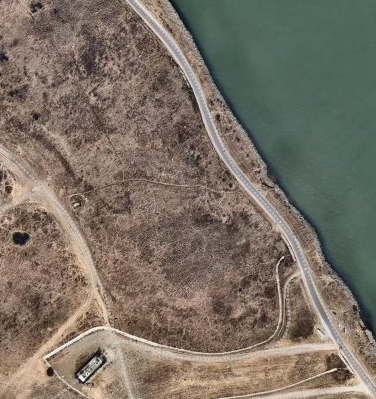

In [8]:
Image.fromarray(tiled_image_data.value)

### Create Label using Annotation Type Objects
* It is recommended to use the Python SDK's annotation types for importing into Labelbox.

### Object Annotations

In [9]:
def create_objects():
  # Point Annotation
  point = Point(x=100,y=100)
  point_annotation = ObjectAnnotation(value=point, name="point")
  # Bounding Box Annotation
  rectangle = Rectangle(start=Point(x=30,y=30), end=Point(x=200,y=200))
  rectangle_annotation = ObjectAnnotation(value=rectangle, name="box")
  # Polyline Annotation
  line = Line(points=[Point(x=60,y=70), Point(x=65,y=100), Point(x=80,y=130), Point(x=40,y=200)])
  line_annotation = ObjectAnnotation(value=line, name="line")
  # Polygon Annotation
  hsv = cv2.cvtColor(tiled_image_data.value, cv2.COLOR_RGB2HSV)
  mask = cv2.inRange(hsv, (50, 10, 25), (100, 150, 255))
  kernel = np.ones((5, 5), np.uint8)
  mask = cv2.erode(mask, kernel)
  mask = cv2.dilate(mask, kernel)
  mask_annotation = MaskData.from_2D_arr(mask)
  mask_data = Mask(mask=mask_annotation, color=[255, 255, 255])
  h, w, _ = tiled_image_data.value.shape
  pixel_bounds = TiledBounds(epsg=EPSG.SIMPLEPIXEL,
                            bounds=[Point(x=0, y=0),
                                    Point(x=w, y=h)])
  transformer = EPSGTransformer.create_pixel_to_geo_transformer(
      src_epsg=pixel_bounds.epsg,
      pixel_bounds=pixel_bounds,
      geo_bounds=tiled_image_data.tile_bounds,
      zoom=17)
  pixel_polygons = mask_data.shapely.simplify(3)
  geo_polygon = transformer(Polygon.from_shapely(pixel_polygons))
  polygon_annotation = ObjectAnnotation(value=geo_polygon, name="polygon")
  return point_annotation, rectangle_annotation, line_annotation, polygon_annotation

### Classification Annotations

In [10]:
def create_classifications():
  # Text Classification
  text = Text(answer="the answer to the text question")
  text_annotation = ClassificationAnnotation(value=text, name="text")
  # Checklist Classification
  checklist = Checklist(answer=[ClassificationAnswer(name="first_checklist_answer"),ClassificationAnswer(name="second_checklist_answer")])
  checklist_annotation = ClassificationAnnotation(value=checklist, name="checklist")
  # Radio Classification
  radio = Radio(answer = ClassificationAnswer(name = "second_radio_answer"))
  radio_annotation = ClassificationAnnotation(value=radio, name="radio")
  return checklist_annotation, radio_annotation, text_annotation

### Create a Label object with all of our annotations

In [11]:
datarow_id = next(dataset.data_rows()).uid
tiled_image_data.uid = datarow_id

point_annotation, rectangle_annotation, line_annotation, polygon_annotation = create_objects()
checklist_annotation, radio_annotation, text_annotation = create_classifications()

label = Label(
    data=tiled_image_data,
    annotations = [
        point_annotation, rectangle_annotation, line_annotation, polygon_annotation,
        text_annotation, checklist_annotation, radio_annotation
    ]
)

# Create urls to mask data for upload
def signing_function(obj_bytes: bytes) -> str:
    url = client.upload_data(content=obj_bytes, sign=True)
    return url


label.add_url_to_masks(signing_function)

label.__dict__

{'annotations': [ObjectAnnotation(name='point', feature_schema_id=None, extra={}, value=Point(extra={}, x=100.0, y=100.0), classifications=[]),
  ObjectAnnotation(name='box', feature_schema_id=None, extra={}, value=Rectangle(extra={}, start=Point(extra={}, x=30.0, y=30.0), end=Point(extra={}, x=200.0, y=200.0)), classifications=[]),
  ObjectAnnotation(name='line', feature_schema_id=None, extra={}, value=Line(extra={}, points=[Point(extra={}, x=60.0, y=70.0), Point(extra={}, x=65.0, y=100.0), Point(extra={}, x=80.0, y=130.0), Point(extra={}, x=40.0, y=200.0)]), classifications=[]),
  ObjectAnnotation(name='polygon', feature_schema_id=None, extra={}, value=Polygon(extra={}, points=[Point(extra={}, x=-122.31704253148526, y=37.87398109727749), Point(extra={}, x=-122.3169872893932, y=37.87385883871054), Point(extra={}, x=-122.3169665736087, y=37.87385272577688), Point(extra={}, x=-122.31695621571643, y=37.873809935226944), Point(extra={}, x=-122.31692168940889, y=37.873779370533214), Point(

### Model Assisted Labeling 

To do model-assisted labeling, we need to convert a Label object into an NDJSON. 

This is easily done with using the NDJSONConverter class

We will create a Label called mal_label which has the same original structure as the label above

Notes:
* the NDJsonConverter takes in a list of labels

In [ ]:
mal_label = Label(
    data=tiled_image_data,
    annotations = [
        point_annotation, rectangle_annotation, line_annotation, polygon_annotation,
        text_annotation, checklist_annotation, radio_annotation
    ]
)


label.add_url_to_masks(signing_function)

ndjson_labels = list(NDJsonConverter.serialize([mal_label]))

ndjson_labels

In [13]:
upload_job = MALPredictionImport.create_from_objects(
    client = client, 
    project_id = mal_project.uid, 
    name="upload_label_import_job_2", 
    predictions=ndjson_labels)

In [14]:
# Errors will appear for each annotation that failed.
# Empty list means that there were no errors
# This will provide information only after the upload_job is complete, so we do not need to worry about having to rerun
print("Errors:", upload_job.errors)

INFO:labelbox.schema.annotation_import:Sleeping for 10 seconds...


Errors: []


### Label Import

Label import is very similar to model-assisted labeling. We will create a Label called li_label which has the same original structure as the label above

In [ ]:
#for the purpose of this notebook, we will need to reset the schema ids of our checklist and radio answers
point_annotation, rectangle_annotation, line_annotation, polygon_annotation = create_objects()
checklist_annotation, radio_annotation, text_annotation = create_classifications()

li_label = Label(
    data=tiled_image_data,
    annotations = [
        point_annotation, rectangle_annotation, line_annotation, polygon_annotation,
        text_annotation, checklist_annotation, radio_annotation
    ]
)

ndjson_labels = list(NDJsonConverter.serialize([li_label]))

ndjson_labels

In [16]:
upload_job = LabelImport.create_from_objects(
    client = client, 
    project_id = li_project.uid, 
    name="upload_label_import_job", 
    labels=ndjson_labels)

In [17]:
print("Errors:", upload_job.errors)

INFO:labelbox.schema.annotation_import:Sleeping for 10 seconds...


Errors: []
